In [17]:
# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Other common imports
import numpy as np
import os
from pathlib import Path

from matplotlib import pyplot as plt

In [2]:
#Tackling the SketchRNN Dataset

DOWNLOAD_ROOT = "http://download.tensorflow.org/data/"
FILENAME = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME,
                                DOWNLOAD_ROOT + FILENAME,
                                cache_subdir="datasets/quickdraw",
                                extract=True)

1065304064/1065301781 [==============================] - 162s 0us/step


In [5]:
quickdraw_dir = Path(filepath).parent
train_files = sorted([str(path) for path in quickdraw_dir.glob("training.tfrecord-*")])
eval_files = sorted([str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")])

In [6]:
train_files

['/home/sfefilatyev/.keras/datasets/quickdraw/training.tfrecord-00000-of-00010',
 '/home/sfefilatyev/.keras/datasets/quickdraw/training.tfrecord-00001-of-00010',
 '/home/sfefilatyev/.keras/datasets/quickdraw/training.tfrecord-00002-of-00010',
 '/home/sfefilatyev/.keras/datasets/quickdraw/training.tfrecord-00003-of-00010',
 '/home/sfefilatyev/.keras/datasets/quickdraw/training.tfrecord-00004-of-00010',
 '/home/sfefilatyev/.keras/datasets/quickdraw/training.tfrecord-00005-of-00010',
 '/home/sfefilatyev/.keras/datasets/quickdraw/training.tfrecord-00006-of-00010',
 '/home/sfefilatyev/.keras/datasets/quickdraw/training.tfrecord-00007-of-00010',
 '/home/sfefilatyev/.keras/datasets/quickdraw/training.tfrecord-00008-of-00010',
 '/home/sfefilatyev/.keras/datasets/quickdraw/training.tfrecord-00009-of-00010']

In [7]:
eval_files

['/home/sfefilatyev/.keras/datasets/quickdraw/eval.tfrecord-00000-of-00010',
 '/home/sfefilatyev/.keras/datasets/quickdraw/eval.tfrecord-00001-of-00010',
 '/home/sfefilatyev/.keras/datasets/quickdraw/eval.tfrecord-00002-of-00010',
 '/home/sfefilatyev/.keras/datasets/quickdraw/eval.tfrecord-00003-of-00010',
 '/home/sfefilatyev/.keras/datasets/quickdraw/eval.tfrecord-00004-of-00010',
 '/home/sfefilatyev/.keras/datasets/quickdraw/eval.tfrecord-00005-of-00010',
 '/home/sfefilatyev/.keras/datasets/quickdraw/eval.tfrecord-00006-of-00010',
 '/home/sfefilatyev/.keras/datasets/quickdraw/eval.tfrecord-00007-of-00010',
 '/home/sfefilatyev/.keras/datasets/quickdraw/eval.tfrecord-00008-of-00010',
 '/home/sfefilatyev/.keras/datasets/quickdraw/eval.tfrecord-00009-of-00010']

In [8]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()
    
with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [9]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [10]:
sorted(class_names)

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

In [11]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [12]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [13]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [14]:
for sketches, lengths, labels in train_set.take(1):
    print("sketches =", sketches)
    print("lengths =", lengths)
    print("labels =", labels)

sketches = tf.Tensor(
[[[-0.02843601  0.1882353   1.        ]
  [-0.50710905  0.13725491  0.        ]
  [-0.04265404  0.14509803  1.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.02830189 -0.01568627  0.        ]
  [ 0.00943395 -0.06666666  0.        ]
  [-0.00943395 -0.2352941   0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[-0.01351351  0.14509805  0.        ]
  [ 0.05405402  0.1764706   0.        ]
  [ 0.01351351  0.2509804   0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[-0.00784314 -0.03370789  0.        ]
  [-0.03529412 -0.04494381  0.        ]
  [-0.03529413 -0.00561798  0.        ]
  ...
  [ 0.10196081 -0.0224719   0.        ]
  [ 0.01176471  0.03370786  0.        ]
  [ 0.02745098 -0.0168

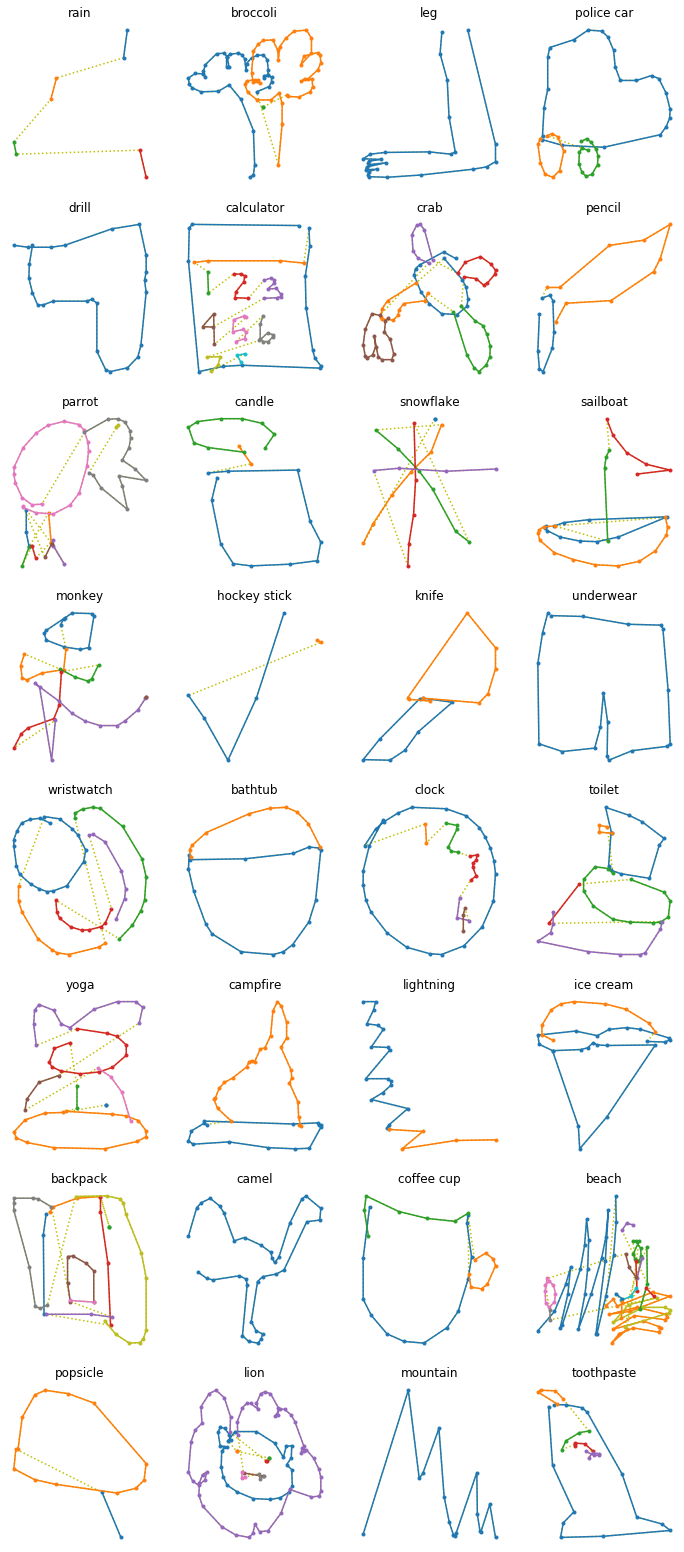

In [18]:
def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = np.cumsum(sketch[:, :2], axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)